In [1]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import optax

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

num_dq = 5 | num_sq = 4


(<Figure size 1920x1440 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

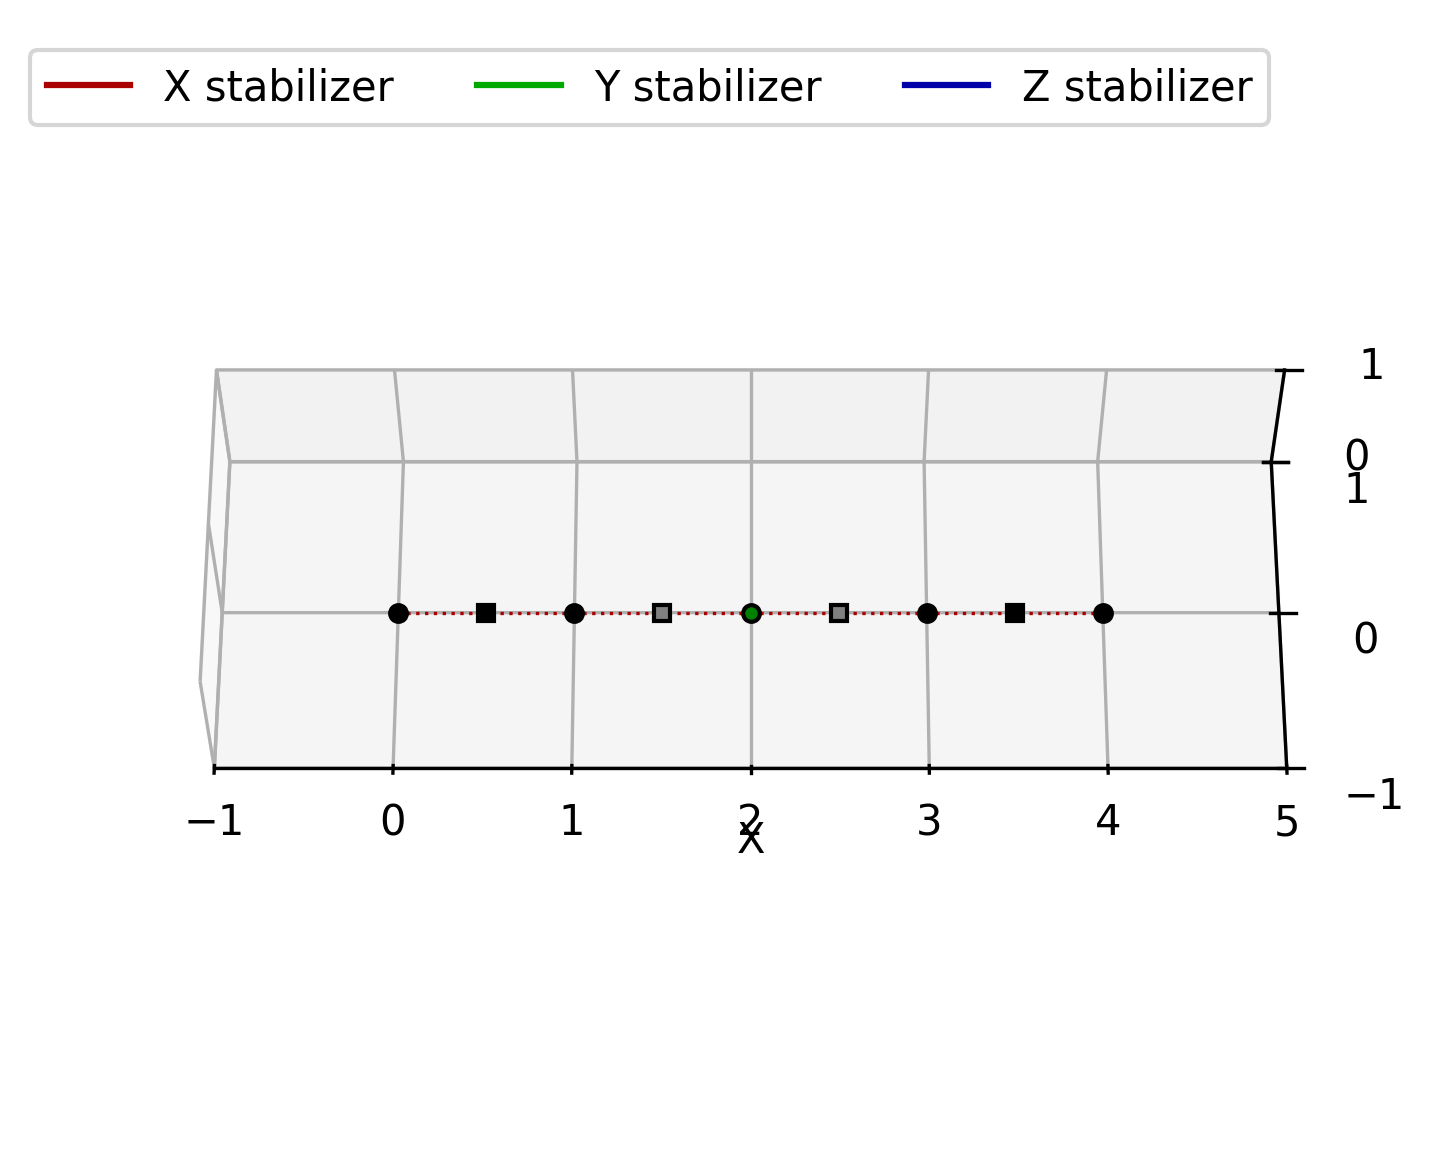

In [2]:
d = 5
px, py, pz = .1, .1, .1

# qec = QEC(surface_code_data(d))
qec = QEC(repetion_code_data(d, 'x'))

Mx, My, Mz = qec.transformation_matrix()
num_sq, num_dq = Mx.shape
print(f'{num_dq = } | {num_sq = }')

subkey, key = jax.random.split(key)
errors=jax_create_error_batch(px, py, pz, num_dq, batch_size=1 ,key=subkey)
qec.show(marker_size=40/d, errors=errors[0])

# Setup neural network

In [3]:
def interpretate_NN_output(NN_output: jnp.ndarray, num_dq: int) -> jnp.ndarray:
    """
    Uses the floating value in the range of 0 and 1 as a probability for the predicted value
    """
    logits = NN_output.reshape((4, num_dq))
    probabilities = jnp.exp(logits) / jnp.sum(jnp.exp(logits), axis=0)
    return probabilities

batch_interpretate_NN_output = jax.vmap(
    interpretate_NN_output, 
    in_axes=(0, None), 
    out_axes=0
)

In [4]:
def correction_prob_to_syndrome(Mx: jnp.ndarray, My: jnp.ndarray, Mz: jnp.ndarray, NN_correction: jnp.ndarray) -> jnp.ndarray:
    syndrome_continius = \
        jnp.matmul(Mx, NN_correction[1]) +\
        jnp.matmul(My, NN_correction[2]) +\
        jnp.matmul(Mz, NN_correction[3])
    # sin(pi/2 * x)**2 Replaces x mod 2
    return jnp.sin(jnp.pi/2*syndrome_continius)**2 

batch_correction_prob_to_syndrome = jax.vmap(
    correction_prob_to_syndrome, 
    in_axes=(None, None, None, 0), 
    out_axes=0
)

In [5]:
# Create a neural network
NN_batch = vmap( NN, in_axes = [0,None], out_axes = 0)

# batch-averaged mean-square-error deviation between x and y_target:
def mse_loss_batch(Mx: jnp.ndarray, My: jnp.ndarray, Mz: jnp.ndarray, 
                   actual_syndrome: jnp.ndarray, params):
    batch_size = actual_syndrome.shape[0]
    # Get the output of the NN
    NN_output = NN_batch(actual_syndrome, params)
    # The probability distribution of the correction proposed by the NN
    NN_correction = batch_interpretate_NN_output(NN_output, num_dq)
    # An interpretation of the syndrome that would result from the QEC recovery proposed by the NN
    NN_syndromes = batch_correction_prob_to_syndrome(Mx, My, Mz, NN_correction)
    # Optimally the NN_syndrome would always be equal to the actual_syndrome
    # This is always the case for algorithmic decoders
    return jnp.sum((NN_syndromes - actual_syndrome)**2) / batch_size

# take gradient with respect to params (argument number '2' out of 0,1,2)
# also return value of loss:
mse_loss_batch_val_grad = value_and_grad(mse_loss_batch, argnums=4)

mse_loss_batch_val_grad = jax.jit( mse_loss_batch_val_grad  )

# number of neurons in each hidden layer:
num_neurons_layers = [num_sq, 2*num_dq, 3*num_dq, 4*num_dq]

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, num_neurons_layers )

### Test the untrained neural network

In [6]:
batch_size = 10

subkey, key = jax.random.split(key)
error_batch = jax_create_error_batch(.1, .1, .1, size=num_dq, batch_size=batch_size, key=subkey)
actual_syndrome = jax_get_syndromes_batch(Mx, My, Mz, error_batch)

NN_output = NN_batch(actual_syndrome, params)
NN_correction = batch_interpretate_NN_output(NN_output, num_dq)
mse_loss_batch_val_grad(Mx, My, Mz, actual_syndrome, params)
print("Proposed correction by the NN-model:\n",NN_correction.argmax(axis=1))

print("\nWith prob-syndromes:\n"+'\n'.join([', '.join([f'{v: 7.1%}' for v in sample]) for sample in batch_correction_prob_to_syndrome(Mx, My, Mz, NN_correction)]))

Proposed correction by the NN-model:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 2 0]
 [0 0 0 0 0]
 [0 1 0 1 0]
 [2 2 3 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [3 3 1 2 0]]

With prob-syndromes:
 100.0%,  100.0%,  100.0%,  100.0%
 100.0%,  100.0%,  100.0%,  100.0%
  88.4%,   83.8%,   99.5%,  100.0%
 100.0%,  100.0%,  100.0%,  100.0%
  65.4%,   72.9%,   98.5%,   99.4%
  89.9%,   94.6%,   99.8%,   98.1%
 100.0%,  100.0%,  100.0%,  100.0%
 100.0%,  100.0%,  100.0%,  100.0%
 100.0%,  100.0%,  100.0%,  100.0%
  99.7%,   98.4%,  100.0%,  100.0%


# Train neural network

In [7]:
learning_rate = 1e-2

# get the optimizer:
optimizer = optax.adam( learning_rate )
# initialize the 'state' of the optimizer, by
# telling it about the initial values:
opt_state = optimizer.init( params )

In [8]:
# training parameters
num_training_batches = 1000
batchsize = 512
losses=[]

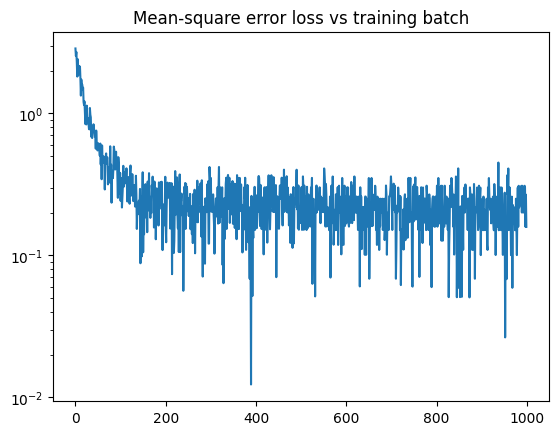

In [9]:
# run this cell multiple times to continue training!

for idx_batch in range(num_training_batches):
    print(f'{idx_batch+1} of {num_training_batches}', end='\r')

    # get training batch
    subkey, key = jax.random.split(key)
    error_batch = jax_create_error_batch(.1, .1, .1, size=num_dq, batch_size=batch_size, key=subkey)
    actual_syndrome = jax_get_syndromes_batch(Mx, My, Mz, error_batch)
    
    # get loss and its gradient with respect to network parameters:
    # mse_loss_batch(Mx: jnp.ndarray, My: jnp.ndarray, Mz: jnp.ndarray, actual_syndrome: jnp.ndarray, samples: int, params, key):
    loss, grads = mse_loss_batch_val_grad(Mx, My, Mz, actual_syndrome, params)

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state )
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()

I:  0.59%	 X:  93.98%	 Y:  93.98%	 Z:  93.98%
I:  5.00%	 X:  1.74%	 Y:  1.74%	 Z:  1.74%
I:  0.26%	 X:  0.13%	 Y:  0.13%	 Z:  0.13%
I:  0.13%	 X:  0.12%	 Y:  0.12%	 Z:  0.12%
I:  81.57%	 X:  11.62%	 Y:  11.62%	 Z:  11.62%
Proposed correction by the NN-model:
 [[1 2 3 3 0]]

With prob-syndromes:
 100.0%,    1.2%,    0.0%,   98.9%


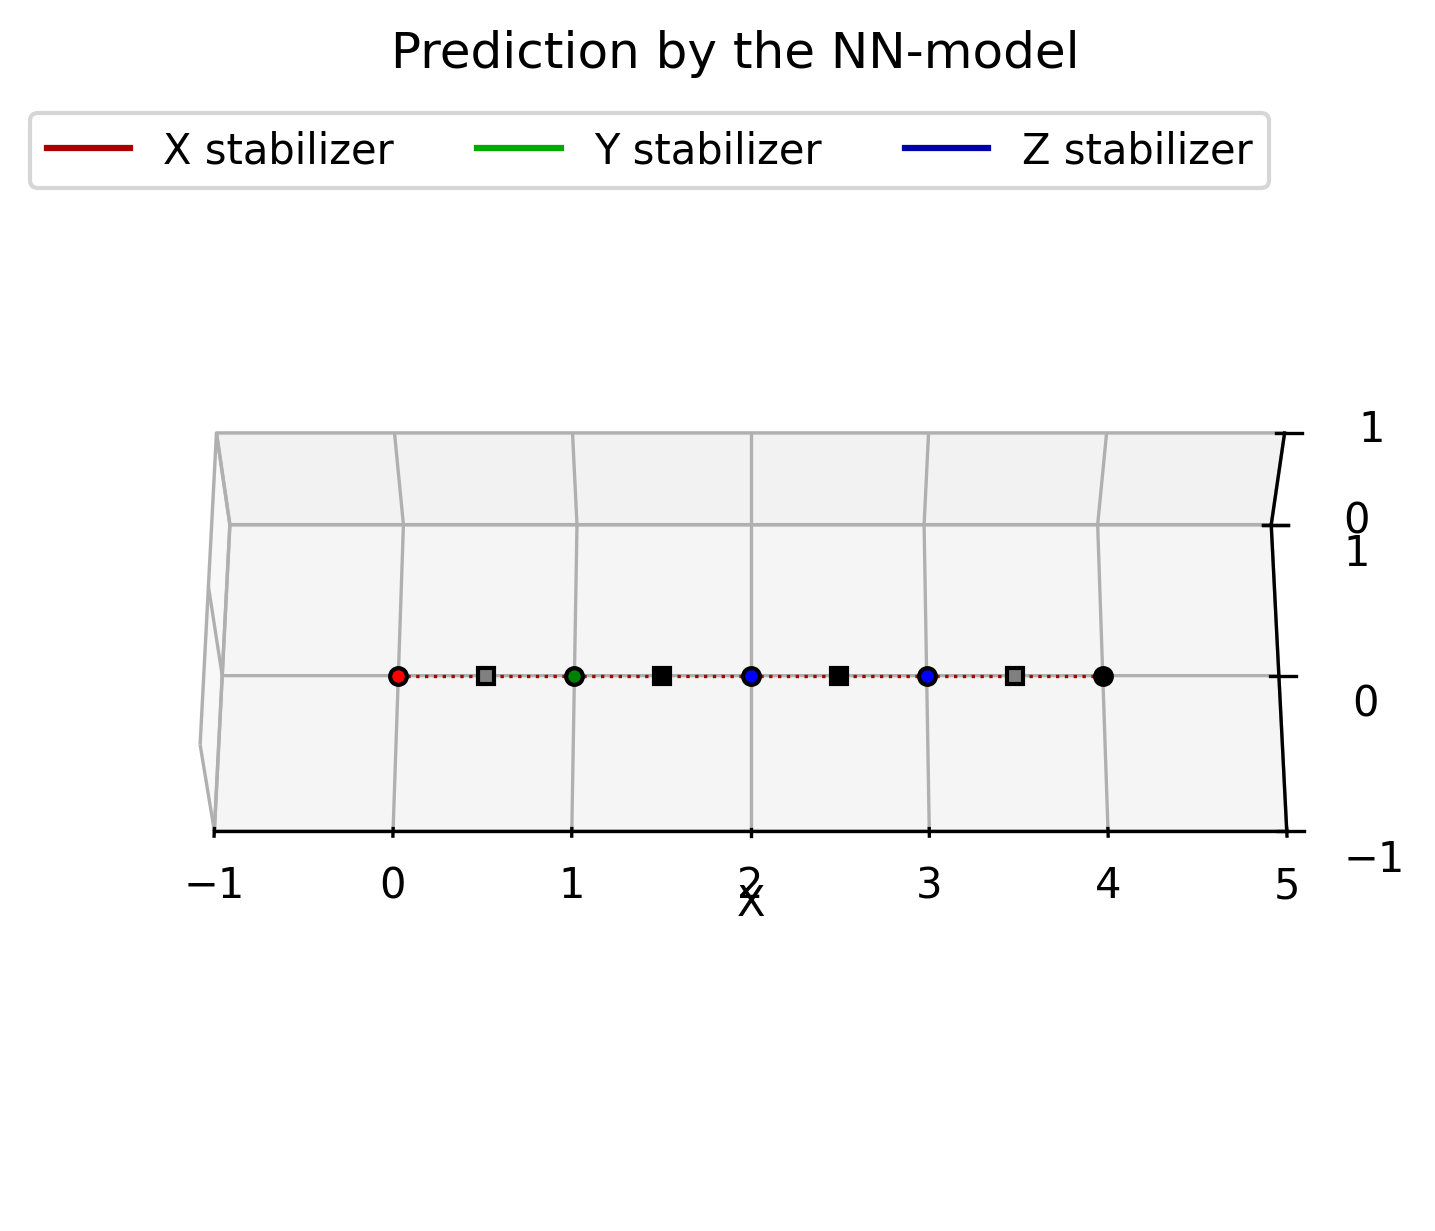

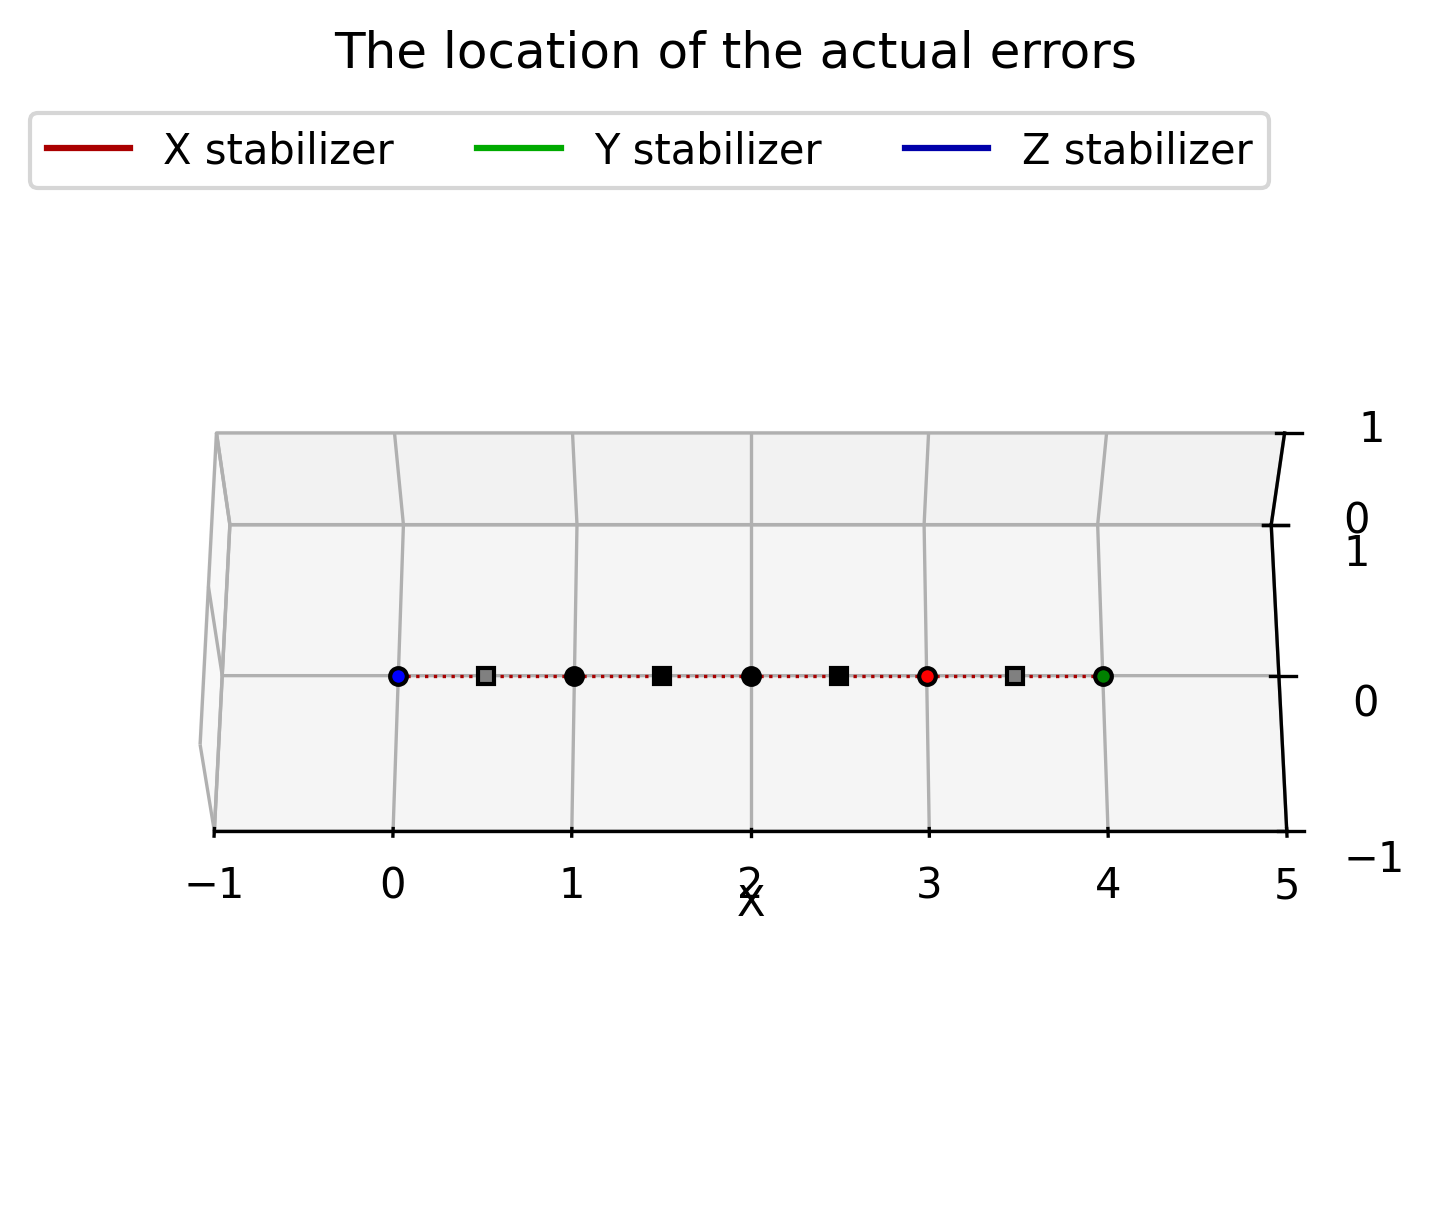

In [10]:
batch_size = 1

subkey, key = jax.random.split(key)
error_batch = jax_create_error_batch(.1, .1, .1, size=num_dq, batch_size=batch_size, key=subkey)
actual_syndrome = jax_get_syndromes_batch(Mx, My, Mz, error_batch)

NN_output = NN_batch(actual_syndrome, params)
NN_correction = batch_interpretate_NN_output(NN_output, d)
mse_loss_batch_val_grad(Mx, My, Mz, actual_syndrome, params)

for I, X, Y, Z in batch_interpretate_NN_output(NN_output, d)[0].T:
    print(f"I: {I: 6.2%}\t X: {X: 6.2%}\t Y: {X: 6.2%}\t Z: {X: 6.2%}")
print("Proposed correction by the NN-model:\n",NN_correction.argmax(axis=1))
print("\nWith prob-syndromes:\n"+'\n'.join([', '.join([f'{v: 7.1%}' for v in sample]) for sample in batch_correction_prob_to_syndrome(Mx, My, Mz, NN_correction)]))

_ = qec.show(marker_size=40/d, errors=NN_correction[0].argmax(axis=0), title="Prediction by the NN-model")
_ = qec.show(marker_size=40/d, errors=error_batch[0], title="The location of the actual errors")